In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
from qutip import *
from scipy.special import erf

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34  # reduced Planck constant
All = 'all'
options = Options()

In [2]:
Nq = 2  # number of levels in qubit
N1 = 3  # number of levels in resonator 1
N2 = 3  # number of levels in resonator 2

wq = 7e9*2*pi  # qubit frequency
"""
What frequency? Of its ground state? Is this the so-called plasma frequency?
"""
wp = wq  # pump frequency
w1 = wq  # resonator 1 frequency
w2 = wq  # resonator 2 frequency

kq = 50e3*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 5e3*2*pi   # photon emission freqency of resonator 1 (resonator 1 decay rate)
k2 = 6e6*2*pi   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 1e6*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 5e6*2*pi  # drive frequency resonator 2, coupling between qubit and resonator 2

Ec = 200e6*2*pi  # Anharmonicity

In [3]:
t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 50e-9   # end Gaussian pulse Omega
t2 = t1 + 10e-9   # start square pulse at resonator 1
t3 = t2 + 300e-9  # end square pulse at resonator 1
t4 = t3 + 10e-9   # start square pulse at resonator 2
t5 = t4 + 300e-9  # end square pulse at resonator 2
t6 = t5 + 10e-9   # t0
tg = 10e-9        # Gaussian rise and fall time of square pulse
"""
Should we divide the times by 2pi in order to be consistant with the radians in the frequencies?
Is this because 
"""

N_repeat = 1  # number of times to repeat cycle
"""
TODO: repeat cycle N_repeat times
"""
Q = 3  # number of std's in Gaussian curves, rises and falls

In [4]:
# Convention:
# [qubit, resonator 1]

# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1-wq)*(w1*a1.dag()*a1) 
      - Ec/2*b.dag()*b.dag()*b*b )

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a2*b.dag() + b*a2.dag())

"""
g1 and E2 differ two orders of magnitude, isn't that a problem?
"""

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q}

In [5]:
def pump_strength(args):
    t0 = args['t0']
    t1 = args['t1']
    Q  = args['Q']
    tau = t1-t0      # pulse duration
    std = tau/(2*Q)  # standard deviation
    time = lambda t : t/(std*sqrt(2))  # t' to pass to error function
    
    """
    TODO: include qubit decay rate kq
    """
    
    integral = sqrt(2*pi)*std*erf(time(tau)/2)
    Omega = pi/integral
    return Omega

# Pump Hamiltonian
Omega = pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame approximation

In [6]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
c_ops = [cq, c1]

# Expectation operators
e_ops = [nq, n1, n2, sx, sy, sz]

In [7]:
def pump(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    Q  = args['Q']
    
    mu = (t1-t0)/2  # pulse center in time domain
    std = (t1-t0)/(2*Q)  # standard deviation
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = exp(-(t-mu)**2/(2*std**2))*confine
    return pulse

In [8]:
def square1(t, args):
    t2 = args['t2']  # start of pulse
    t3 = args['t3']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    Q  = args['Q']
    
    confine = np.heaviside((t-t2), 0) - np.heaviside((t-t3), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : exp(-(t-mu)**2/(2*std**2))  # Gaussian
    
    block = np.heaviside((t-(t2+tg)), 0) - np.heaviside((t-(t3-tg)), 0)
    rise = gauss(t2+tg) * (1-np.heaviside((t-(t2+tg)), 0))
    fall = gauss(t3-tg) * (np.heaviside((t-(t3-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [9]:
def square2(t, args):
    t4 = args['t4']  # start of pulse
    t5 = args['t5']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g2 = args['g2']  # pulse strength
    Q  = args['Q']
    
    confine = np.heaviside((t-t4), 0) - np.heaviside((t-t5), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : exp(-(t-mu)**2/(2*std**2))  # Gaussian
    
    block = np.heaviside((t-(t4+tg)), 0) - np.heaviside((t-(t5-tg)), 0)
    rise = gauss(t4+tg) * (1-np.heaviside((t-(t4+tg)), 0))
    fall = gauss(t5-tg) * (np.heaviside((t-(t5-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [18]:
H = [Hjc, [Hp, pump], [H1, square1], [H2, square2]]  # complete Hamiltonian
tlist = np.linspace(0, 1*N_repeat*t6, int(1e3))  # discrete time steps for which to store the output
psi0 = tensor(basis(Nq,1), basis(N1,0), basis(N2,0))  # initial state
options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

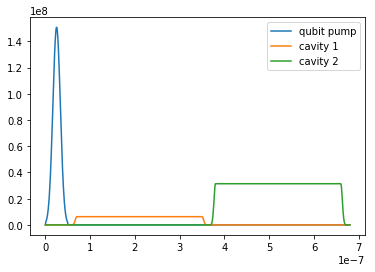

In [19]:
pump_pulse = Omega*pump(tlist, H_args)
sqr1_pulse = g1*square1(tlist, H_args)
sqr2_pulse = g2*square2(tlist, H_args)
plt.plot(tlist, pump_pulse, label='qubit pump')
plt.plot(tlist, sqr1_pulse, label='cavity 1')
plt.plot(tlist, sqr2_pulse, label='cavity 2')
plt.legend()

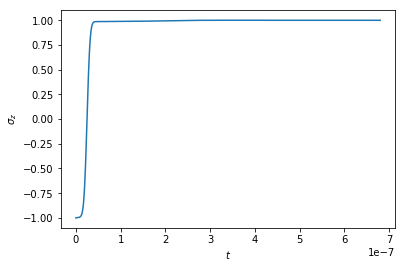

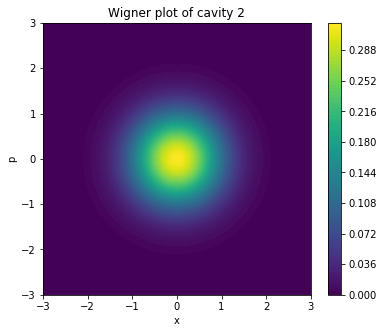

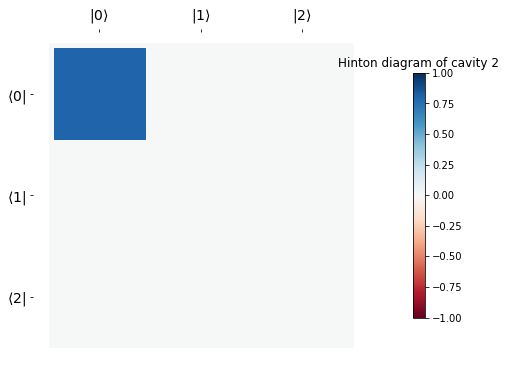

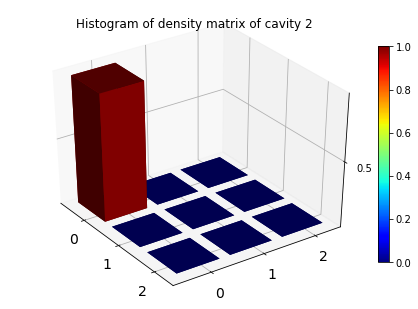

In [25]:
obj = 2    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = 200  # index of tlist

plt.plot(tlist, result.expect[5])
plt.xlabel("$t$")
plt.ylabel("$\\sigma_z$")
cont = plots.wigner(result.states, obj=obj, ind=ind)
plots.dmat_hinton(result.states, obj=obj, ind=ind)
plots.dmat_hist(result.states, obj=obj, ind=ind)